Saving audi_dataset(7a).xlsx to audi_dataset(7a) (2).xlsx
['vin', 'date', 'dealership', 'location', 'year', 'age', 'make', 'model', 'trim', 'awd', 'engine_capacity', 'powertrain', 'transmission', 's_line', 'coupe', 'etron', 'color', 'tint', 'rims', 'day', 'views', 'likes', 'sold', 'ratio', 'price', 'mileage', 'mileage_per_year', 'kbb_low', 'kbb_mid', 'kbb_high', 'ksl_salvage', 'ncib_theft', 'ncib_salvage', 'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 35', 'Unnamed: 36', 'Unnamed: 37', 'Unnamed: 38', 'Unnamed: 39', 'Unnamed: 40', 'Unnamed: 41', 'Unnamed: 42', 'Unnamed: 43', 'Unnamed: 44', 'Unnamed: 45', 'Unnamed: 46', 'Unnamed: 47', 'Unnamed: 48', 'Unnamed: 49', 'Unnamed: 50', 'Unnamed: 51', 'Unnamed: 52']
Index(['dealership', 'model', 'trim', 'awd', 'engine_capacity', 'powertrain',
       'transmission', 's_line', 'coupe', 'etron', 'price', 'mileage_per_year',
       'ncib_salvage'],
      dtype='object')

 Most influential features on price prediction:
                              Feature

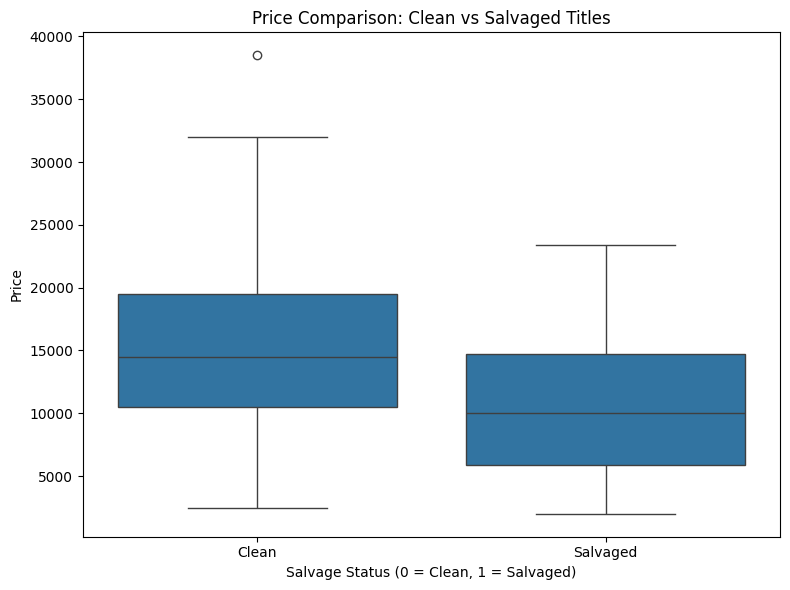

In [3]:
# Imports/Uploads
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from google.colab import files
uploaded = files.upload()

# Load and clean data
df = pd.read_excel("audi_dataset(7a).xlsx")
print(df.columns.tolist())
columns_to_drop = [
    'vin', 'date', 'location', 'make', 'year', 'day', 'views', 'likes',
    'sold', 'ratio', 'kbb_low', 'kbb_mid',
    'ksl_salvage', 'ncib_theft', 'color', 'rims', 'tint', 'age', 'kbb_high', 'mileage'
]
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
print(df.columns)

# Define features
boolean_features = ['dealership','awd','s_line','coupe','etron','ncib_salvage']
numerical_features = ['mileage_per_year']
categorical_features = ['model','trim','engine_capacity','powertrain','transmission']
target = 'price'

# Previous model dropped missing datapoints, which decreased accuracy
# Current model imputes them as shown

# Impute missing datapoints
df[boolean_features] = df[boolean_features].fillna(0)
for col in numerical_features:
    df[col] = df[col].fillna(df[col].median())
    categorical_features = ['model','trim','powertrain','transmission']
for col in categorical_features:
    df[col] = df[col].fillna(df[col].mode()[0])

# Convert boolean features to integers
for col in boolean_features:
    df[col] = df[col].astype(int)

# One-hot encode categorical features
df_encoded = pd.get_dummies(df[boolean_features + numerical_features + categorical_features], drop_first=True)

# Define features (X) and target (y)
X = df_encoded
y = df['price']

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Performed diagnostics below to identify and remove variables with high levels of multicollinearity that were creating noise
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
})
coefficients['Abs_Coefficient'] = np.abs(coefficients['Coefficient'])
coefficients_sorted = coefficients.sort_values(by='Abs_Coefficient', ascending=False)
# Display top 10 most influential features
print("\n Most influential features on price prediction:")
print(coefficients_sorted.head(10))
# Optionally: display bottom 10 least influential features
print("\n Least influential features:")
print(coefficients_sorted.tail(10))

# Predict and evaluate
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("R-squared score on test set:", r2)

# Vehicle prediction example
# define the raw input for vehicle
my_car_raw = {
    'dealership': int(input("From dealership? (1 = yes, 0 = no): ")),
    'model': input("Model (e.g., A3, A4): "),
    'trim': input("Trim (e.g., premium, premium +, manual): "),
    'awd': int(input("All-wheel drive? (1 = yes, 0 = no): ")),
    'engine_capacity': input("Engine capacity (e.g., 1.4, 1.8, 2.0): "),
    'powertrain': input("Powertrain (e.g., tfsi, fsi): "),
    'transmission': input("Transmission (6sp, auto, s tronic; ect): "),
    's_line': int(input("S line? (1 = yes, 0 = no): ")),
    'coupe': int(input("Coupe? (1 = yes, 0 = no): ")),
    'etron': int(input("Etron? (1 = yes, 0 = no): ")),
    'mileage_per_year': int(input("Mileage per year: ")),
    'ncib_salvage': int(input("Salvage? (1 = yes, 0 = no): "))
}

my_car_df_raw = pd.DataFrame([my_car_raw])

my_car_df_raw[boolean_features] = my_car_df_raw[boolean_features].fillna(0).astype(int)
for col in numerical_features:
    if col != 'price':
        if my_car_df_raw[col].isnull().any():
            my_car_df_raw[col] = my_car_df_raw[col].fillna(df[col].median())
for col in categorical_features:
    if my_car_df_raw[col].isnull().any():
        my_car_df_raw[col] = my_car_df_raw[col].fillna(df[col].mode()[0])

# one-hot encode to match training data
my_car_encoded = pd.get_dummies(my_car_df_raw[boolean_features + numerical_features + categorical_features], drop_first=True)
# align columns with training features
my_car_encoded = my_car_encoded.reindex(columns=X.columns, fill_value=0)

# predict price
predicted_price = model.predict(my_car_encoded)[0]
print(f"\nEstimated price for your vehicle: ${predicted_price:,.2f}")

# Visualizing
import seaborn as sns
import matplotlib.pyplot as plt
## relationship between single variable and price
#plt.figure(figsize=(8, 6))
#sns.regplot(x='mileage', y='price', data=df, scatter_kws={'alpha':0.5})
#plt.title('Mileage vs Price')
#plt.xlabel('Mileage')
#plt.ylabel('Price')
#plt.tight_layout()
#plt.show()
## relative impact of each variable
#top_coef_df = coef_df.sort_values(by='Coefficient', key=abs, ascending=False).head(15)
#plt.figure(figsize=(10, 6))
#plt.barh(top_coef_df['Feature'], top_coef_df['Coefficient'])
#plt.xlabel("Coefficient (Impact on Price)")
#plt.title("Top 15 Most Impactful Features")
#plt.gca().invert_yaxis()
#plt.tight_layout()
#plt.show()
plt.figure(figsize=(8, 6))
sns.boxplot(x='ncib_salvage', y='price', data=df)
plt.title('Price Comparison: Clean vs Salvaged Titles')
plt.xlabel('Salvage Status (0 = Clean, 1 = Salvaged)')
plt.ylabel('Price')
plt.xticks([0, 1], ['Clean', 'Salvaged'])
plt.tight_layout()
plt.show()